# Rules Extraction

# Statics

In [15]:
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.utils import Bunch
from sklearn.datasets._base import load_csv_data
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import csv

## Load Dataset

In [16]:
# Load Dataset
#iris
#dataset = load_iris()
target_value_name = 'class'

# Mushrooms
filename = 'mushrooms'
target_true = 'p'
target_false = 'e'
test_size = 0.2


data_file_name = f'../../data/{filename}.csv'
pandas_dataset = pd.read_csv(data_file_name)
pandas_dataset = pandas_dataset.replace('?', 'unknown')
pandas_dataset = pandas_dataset.dropna()
pandas_dataset.columns = [sub.replace('%', '') for sub in pandas_dataset.columns]
target_value_name = pandas_dataset.columns[-1]

pandas_dataset[target_value_name] = pandas_dataset[target_value_name].map({target_false:0,target_true:1})

pandas_dataset.columns = [sub.replace('-', '_').replace(' ', '').replace('class', 'target_value') for sub in pandas_dataset.columns]
target_value_name = pandas_dataset.columns[-1]
feature_names = pandas_dataset.columns[0:-1]


#dataset.feature_names = [sub.replace(' ', '').replace('(cm)', '') for sub in dataset.feature_names]

pandas_dataset.head()

,cap_shape,cap_surface,cap_color,bruises3F,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,...,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat,target_value
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,1
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,0
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,0
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,1
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,0


# One Hot Encoding

In [17]:
def one_hot_encode_dataframe(data, feature_names):
    enc = OneHotEncoder(sparse_output=False)
    encoded_array = enc.fit_transform(data.loc[:,feature_names])
    encoded_feature_names = enc.get_feature_names_out()
    df_encoded = pd.DataFrame(encoded_array,columns=encoded_feature_names)
    encoded_pandas_dataset = pd.concat([df_encoded, data],axis=1)
    encoded_pandas_dataset.drop(labels= feature_names,axis=1,inplace=True)
    return encoded_pandas_dataset, encoded_feature_names

encoded_pandas_dataset, encoded_feature_names = one_hot_encode_dataframe(pandas_dataset, feature_names)
encoded_pandas_dataset.head()

,cap_shape_b,cap_shape_c,cap_shape_f,cap_shape_k,cap_shape_s,cap_shape_x,cap_surface_f,cap_surface_g,cap_surface_s,cap_surface_y,...,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,target_value
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


In [18]:
X = encoded_pandas_dataset[encoded_feature_names]
y = encoded_pandas_dataset[target_value_name]

encoded_dataset = Bunch(
        data=X.to_numpy(),
        target=y.to_numpy(),
        target_names=target_value_name,
        feature_names=X.columns
)

#X_display = pandas_dataset.drop([target_value_name], axis=1)
#y_display = pandas_dataset[target_value_name]

#encoded_pandas_dataset = pd.DataFrame(data= np.c_[dataset['data'], dataset['target']], columns= list(dataset['feature_names']) + ['target'])
#encoded_pandas_dataset.head()


# Divide dataset

In [19]:
#Define dataset
X_train, X_test, y_train, y_test = train_test_split(encoded_dataset.data, encoded_dataset.target, test_size=test_size, random_state=1)
encoded_train_pandas_dataset = pd.DataFrame(data= np.c_[X_train, y_train], columns= list(encoded_dataset['feature_names']) + [target_value_name])
encoded_test_pandas_dataset = pd.DataFrame(data= np.c_[X_test, y_test], columns= list(encoded_dataset['feature_names']) + [target_value_name])
print()
print('Sizes (without target):')
print(f'Original size {encoded_dataset.data.shape}')
print(f'Train size {X_train.shape}')
print(f'Test size {X_test.shape}')


Sizes (without target):
Original size (8124, 117)
Train size (6499, 117)
Test size (1625, 117)


## Define Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer, recall_score, accuracy_score

# Define scorer
ensemble = RandomForestClassifier(n_estimators=100)
ensemble.fit(X_train, y_train)

RandomForestClassifier()

## iPRules

->Check Ensemble Model is fitted
->Extract feature importance list


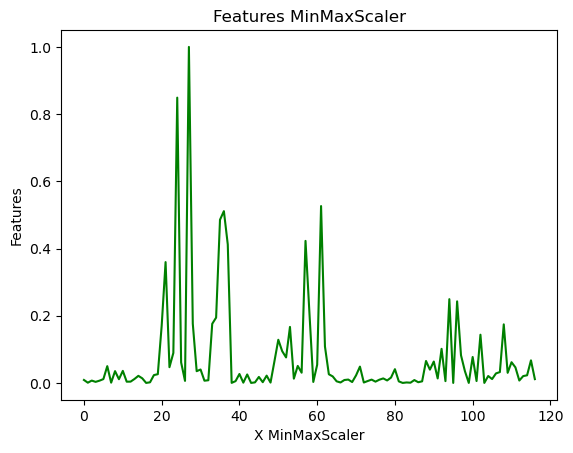

	 Original features 117
	 Selected features 48
	 Percentage of selected rules: 41.02564102564103 %
->Generate new tree based on list


In [ ]:
from iPRules.iPRules import iPRules

# initialize
#rules = iPRules(
#                base_ensemble=ensemble,
#                feature_names=encoded_dataset.feature_names,
#                target_value_name = encoded_dataset.target_names,
#                chi_square_probability = 0.95,
#                scale_feature_coefficient = 0.1,
#                min_accuracy_coefficient = 0.9,
#                min_number_class_per_node = 3
#            )
rules = iPRules(
                base_ensemble=ensemble,
                feature_names=encoded_dataset.feature_names,
                target_value_name = encoded_dataset.target_names,
                chi_square_probability = 0.95,
                scale_feature_coefficient = 0.03,
                min_accuracy_coefficient = 0.9,
                min_number_class_per_node = 5
            )
# Fit model
rules.fit(encoded_train_pandas_dataset)

# Print Model

In [ ]:
# DISPLAY DESCRIPTION
print(rules.description())
# DISPLAY ALL RULES
#print(rules)

# Predict

In [ ]:
# ENSEMBLE
y_pred_test_ensemble = ensemble.predict(X_test)

# RULES
y_pred_test_rules = rules.predict(X_test)

In [ ]:
# CATEGORIZABLES
np_array_rules = np.array(y_pred_test_rules)
#not_filter_indices = np.where(np.logical_and(np_array_rules != 0, np_array_rules!=1))[0]
filter_indices = np.where(np_array_rules != None)[0]


np_filterred_y_test = np.array(y_test)[filter_indices]
np_filterred_y_pred_test_ensemble = np.array(y_pred_test_ensemble)[filter_indices]
np_filterred_y_pred_test_rules = np.array(y_pred_test_rules)[filter_indices]
# CHANGE FORMAT IN ORDER TO NOT HAVE PROBLEMS
np_filterred_y_pred_test_rules = np_filterred_y_pred_test_rules.astype('int64')


print(f'DATASET TEST: {len(y_test)}')
print(f'DATASET TEST categorizable: {len(np_filterred_y_test)}')
print('Cobertura:',str("{:.2f}".format(100*(len(np_filterred_y_pred_test_rules)/len(y_test))))+'%')

ensemble_accuracy = metrics.accuracy_score(np_filterred_y_test, np_filterred_y_pred_test_ensemble, normalize=True)
print('RF accuracy:',str("{:.2f}".format(100*ensemble_accuracy))+'%')
rules_accuracy = metrics.accuracy_score(np_filterred_y_test, np_filterred_y_pred_test_rules, normalize=True)
print('Rules Accuracy:',str("{:.2f}".format(100*rules_accuracy))+'%')


# CONFUSION MATRIX

In [ ]:

confusion_matrix = metrics.confusion_matrix(np_filterred_y_test, np_filterred_y_pred_test_rules)
print(confusion_matrix)
confusion_matrix(np_filterred_y_test, np_filterred_y_pred_test_rules, labels=encoded_dataset.feature_names)

# SHAP explainer

In [ ]:
import shap

# Create Tree Explainer object that can calculate shap values
explainer = shap.TreeExplainer(ensemble)

# Evaluate SHAP values
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_train, feature_names=encoded_dataset.feature_names)